In [1]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOAgent
from neurocuts_env import NeuroCutsEnv
from run_neurocuts import on_episode_end
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from mask import PartitionMaskModel
from tree import Node
from tree import load_rules_from_file

%load_ext autoreload
%autoreload 2

In [2]:
### Init ###
ray.init()

2020-05-08 23:32:43,263	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-08 23:32:43,301	INFO resource_spec.py:216 -- Starting Ray with 15.38 GiB memory available for workers and up to 7.7 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.0.28',
 'redis_address': '192.168.0.28:60462',
 'object_store_address': '/tmp/ray/session_2020-05-08_23-32-43_262970_14320/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-05-08_23-32-43_262970_14320/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-05-08_23-32-43_262970_14320'}

In [3]:
rules = os.path.abspath("neurocuts-master/classbench/{}".format("acl5_1k"))
dump_dir = "/tmp/neurocuts_out"
reward_shape = "linear"

In [4]:
### Setup ###
register_env(
    "tree_env", lambda env_config: NeuroCutsEnv(
        env_config["rules"],
        max_depth=env_config["max_depth"],
        max_actions_per_episode=env_config["max_actions"],
        dump_dir=env_config["dump_dir"],
        depth_weight=env_config["depth_weight"],
        reward_shape=env_config["reward_shape"],
        partition_mode=env_config["partition_mode"]))
ModelCatalog.register_custom_model("mask", PartitionMaskModel)

config =  {
        "num_gpus": 0,
        "num_workers": 3,
        "sgd_minibatch_size": 100,
        "sample_batch_size": 200,
        "train_batch_size": 1000,
        "batch_mode": "complete_episodes",
        "observation_filter": "NoFilter",
        "model": {
            "custom_model": "mask",
            "fcnet_hiddens": [512, 512],
        },
        "vf_share_layers": True,
        "entropy_coeff": 0.01,
        "callbacks": {
            "on_episode_end": tune.function(on_episode_end),
        },
        "env_config": {
            "dump_dir": dump_dir,
            "partition_mode": None,
            "reward_shape": reward_shape,
            "max_depth": 100,
            "max_actions": 1000,
            "depth_weight": 1.0,
            "rules": rules,
        },
    }

2020-05-08 23:33:57,484	WARNING sample.py:31 -- DeprecationWarning: wrapping <function on_episode_end at 0x7f1f8c55add0> with tune.function() is no longer needed


In [9]:
file = "/home/jaaoliveira/ray_results/neurocuts_None/PPO_tree_env_33c83386_2020-05-08_23-21-41637am38c/checkpoint_51/checkpoint-51"
env = NeuroCutsEnv(rules_file=rules)
agent = PPOAgent(env="tree_env", config=config)
agent.restore(file)

/home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-05-08 23:37:27,911	WARNING __init__.py:54 -- DeprecationWarning: PPO has been renamed to ray.rllib.agents.trainer_template.PPO. This will raise an error in the future.
/home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(pid=15575) /home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=15575)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=15573) /home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=15573)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=15580) /home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=15580)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2020-05-08 23:37:32,734	INFO trainable.py:346 -- Restored from checkpoint: /home/jaaoliveira/ray_results/neurocuts_None/PPO_tree_env_33c83386_2020-05-08_23-21-41637am38c/checkpoint_51/checkpoint-51
2020-05-08 23:37:32,735	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 51, '_timesteps_total': 100292, '_time_total': 498.8530025482178, '_episodes_total': 1187}


(pid=15579) /home/jaaoliveira/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=15579)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [34]:
# directory = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_0_2019-03-08_23-48-42pb2k3nsd"
# directory = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_0_2019-03-20_20-38-09ixikyqq8/"
directory = "/Users/yitianzou/ray_results/neurocuts_None/PPO_tree_env_0_2019-03-27_16-29-19mwsnjoc7"
env = NeuroCutsEnv(rules_file=rules)

agent_1 = PPOAgent(env="tree_env", config=config)
agent_1.restore(directory+"/checkpoint_1/checkpoint-1")
agent_1M = PPOAgent(env="tree_env", config=config)
agent_1M.restore(directory+"/checkpoint_23/checkpoint-23")
agent_2M = PPOAgent(env="tree_env", config=config)
agent_2M.restore(directory+"/checkpoint_54/checkpoint-54")
agent_4M = PPOAgent(env="tree_env", config=config)
agent_4M.restore(directory+"/checkpoint_136/checkpoint-136")
agent_8M = PPOAgent(env="tree_env", config=config)
agent_8M.restore(directory+"/checkpoint_318/checkpoint-318")

2019-03-30 10:04:00,561	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.


/Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2019-03-30 10:04:01,628	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


(pid=98106) 2019-03-30 10:04:06,439	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=98106) 2019-03-30 10:04:06.440239: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98100) 2019-03-30 10:04:06,439	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 3 on CPU (please ignore any CUDA init errors)
(pid=98100) 2019-03-30 10:04:06.440425: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98101) 2019-03-30 10:04:06,438	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 2 on CPU (please ignore any CUDA init errors)
(pid=98101) 2019-03-30 10:04:06.440439: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FM

2019-03-30 10:04:06,949	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)


(pid=98106) WARNING:tensorflow:From /Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
(pid=98106) Instructions for updating:
(pid=98106) Deprecated in favor of operator or tf.math.divide.
(pid=98100) WARNING:tensorflow:From /Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
(pid=98100) Instructions for updating:
(pid=98100) Deprecated in favor of operator or tf.math.divide.
(pid=98101) WARNING:tensorflow:From /Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
(pid=98101) Instructions for updating:
(pid=98101) Deprecated in favor of operator or tf.math.divide.


2019-03-30 10:04:08,229	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


(pid=98102) 2019-03-30 10:04:09,768	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=98102) 2019-03-30 10:04:09.770128: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98104) 2019-03-30 10:04:09,772	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 3 on CPU (please ignore any CUDA init errors)
(pid=98104) 2019-03-30 10:04:09.774281: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98103) 2019-03-30 10:04:09,765	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 2 on CPU (please ignore any CUDA init errors)
(pid=98103) 2019-03-30 10:04:09.767237: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FM

2019-03-30 10:04:12,084	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-30 10:04:13,097	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


(pid=98098) 2019-03-30 10:04:14,574	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=98098) 2019-03-30 10:04:14.576373: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98099) 2019-03-30 10:04:14,573	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 3 on CPU (please ignore any CUDA init errors)
(pid=98099) 2019-03-30 10:04:14.573995: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98099) WARNING:tensorflow:From /Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=98099) Instructions for updating:
(pid=98099) Colocations handled automatical

2019-03-30 10:04:16,722	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-30 10:04:17,849	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


(pid=98109) 2019-03-30 10:04:19,284	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=98109) 2019-03-30 10:04:19.285397: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=98109) WARNING:tensorflow:From /Users/yitianzou/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=98109) Instructions for updating:
(pid=98109) Colocations handled automatically by placer.
(pid=98107) 2019-03-30 10:04:19,311	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 2 on CPU (please ignore any CUDA init errors)
(pid=98107) 2019-03-30 10:04:19.313001: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to 

2019-03-30 10:04:21,390	INFO policy_evaluator.py:275 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2019-03-30 10:04:22,533	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']


In [10]:
#meta = directory + "/checkpoint_318/checkpoint-318.tune_metadata"
meta = file
with open(meta, 'rb') as f:
    text = pickle.load(f)
print(text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## TODOS
1. Verify that after num-fast # iterations, reward (memory_access) has converged to around 10 - DONE
2. Generate distribution of (src, dst) - DONE
3. Make contour for 1st checkpoint - DONE
4. Vectorize _value - DONE
5. Get checkpoints + run for different ones - DONE
6. Try different initializations of other bits in real_obs
7. Random vector projection?

### Fix

Construct Rule(id=0, ranges=[src_ip_start, src_ip_end, dst_ip_start, dst_ip_end, src_port_start, src_port_end, dst_port_start, dst_port_end, proto_start, proto_end])

Call rule.get_state()

933
268435456


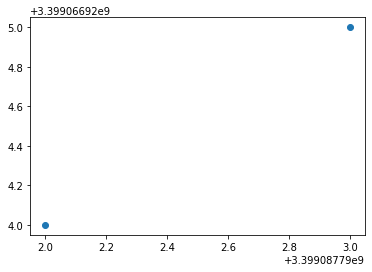

In [35]:
rules = load_rules_from_file("neurocuts-master/classbench/acl5_1k")
X = np.arange(0, 2**32, 2**28)
Y = np.arange(0, 2**32, 2**28)
N = len(X)
r = rules[0]
print(len(rules))
print(X[1])
#print(rules[0].ranges)
# print(rules[100].ranges)
# print(rules[200].ranges)
# print(rules[300].ranges)
# print(rules[400].ranges)
# for i in range(N - 1):
#     for j in range(N - 1):
#         src_ip_range = [X[i], X[i + 1]]
#         dst_ip_range = [Y[i], Y[i + 1]]
#         if src_ip_range[0] < r.ranges[0] < src_ip_

x_pts = [r.ranges[0], r.ranges[1]]
y_pts = [r.ranges[2], r.ranges[3]]
plt.scatter(x_pts, y_pts)

In [36]:
def intersect(sx1, sx2, sy1, sy2, ox1, ox2, oy1, oy2):
    return (sx1 < ox2 and sx2 > ox1) and (sy1 < oy2 and sy2 > oy1)

In [37]:
src_diff = [r.ranges[1] - r.ranges[0] for r in rules]
dst_diff = [r.ranges[3] - r.ranges[2] for r in rules]
print(max(src_diff))
print(max(dst_diff))
print(2**28)

33554432
128
268435456


In [28]:
num_rules = np.zeros((N-1, N-1))
for r in rules:
    for i in range(N-1):
        for j in range(N-1):
            if intersect(r.ranges[0], r.ranges[1], r.ranges[2], r.ranges[3], X[i], X[i+1], Y[j], Y[j+1]):
                num_rules[i, j] += 1

print(num_rules)

[[449.   0.   0.   0.   0.   0.   0.   0.  98.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.  74.   0.  13.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0. 116.  34.   0.   0.   0.   0.   0.
    0.]
 [ 10.   0.   0.   0.   0.   0.   0.   0.  49.   0.   0.   0.   0.   0.
    0.]
 [  6.   0.   0.   0.   0.   0.   0.   0.   0.  26.   0.   0.   0.   0.
    0.]
 [  2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.
    0.]
 [  2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   0.
    0.]
 [  2.   0.   0.   0.   0.   0.   0.   0

In [38]:
def make_binary_list(num):
    b = "{0:b}".format(int(num))
    lst = [float(d) for d in b]
    diff = 32 - len(lst)
    lst = [0.0]*diff + lst
    return lst
def make_dec(ip):
    ip_str = ''.join(str(int(e)) for e in ip)
    ip_dec = int(ip_str, 2)
    return ip_dec
i = 2**8 + 1
b = make_binary_list(i)
print(b)
print(make_dec(b))
b = list(bin(int(i))[2:])
l = [0.0] * (32 - len(b)) + [float(i) for i in b]
print(l)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
257
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [39]:
### Get values ###
def value(policy, obs):
    feed_dict = {
       policy.observations: obs,
    }
    vf = policy.sess.run(policy.value_function, feed_dict)
    return vf

# values_lst = value(agent.get_policy(), obs_lst)
# values = values_lst.reshape((N, N))
# print(values[30][30])

In [40]:
def generate_obs_and_vals(agent):
    max_ip = 2**32
    max_port = 2**16
    max_proto = 2**8
    interval = 2**28
    X = np.arange(0, max_ip, interval)
    Y = np.arange(0, max_ip, interval)
    N = len(X)
    obs_lst = []

    for i in range(N-1): 
        for j in range(N-1):
#             [src_ip_start, src_ip_end, dst_ip_start, dst_ip_end, src_port_start, src_port_end, dst_port_start, dst_port_end, proto_start, proto_end]
#             src = make_binary_list(X[i])
#             dst = make_binary_list(Y[j])
#             size = 279 - 64
#             if mask is None:
#                 mask = [0.0] * size
#             real_obs = src + dst + mask
            ranges = [X[i], X[i+1], Y[j], Y[j+1], 0, max_port, 0, max_port, 0, 2**8]
            node = Node(0, ranges, [], 0, None, None)
            real_obs = node.get_state()
            action_mask = [0.0] * 10
            obs = {"real_obs": real_obs, "action_mask": action_mask}
            _obs = agent.local_evaluator.preprocessors["default"].transform(obs)
            obs_lst.append(_obs)
#     print(obs_lst)
    values_lst = value(agent.get_policy(), obs_lst)
    values = values_lst.reshape((N-1, N-1))
    return X, Y, values

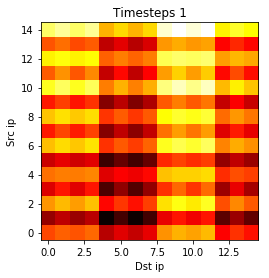

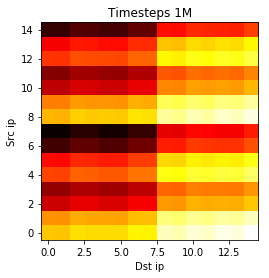

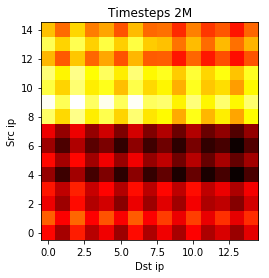

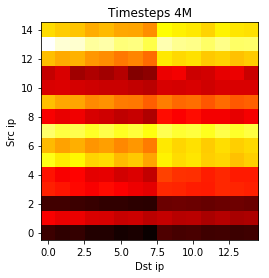

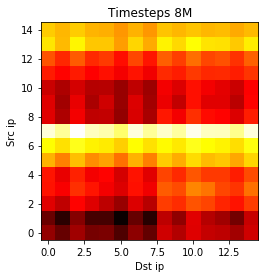

In [53]:
### Visualize ###
def visualize(agent, num):
    X, Y, values = generate_obs_and_vals(agent)
    plt.imshow(values, cmap='hot', interpolation='nearest', origin='lower')
#     _X, _Y = np.meshgrid(X, Y)
#     plt.contour(_X, _Y, values)
    plt.title("Timesteps {}".format(num))
    plt.xlabel("Dst ip")
    plt.ylabel("Src ip")
    plt.show()
    
visualize(agent_1, "1")
visualize(agent_1M, "1M")
visualize(agent_2M, "2M")
visualize(agent_4M, "4M")
visualize(agent_8M, "8M")
# Yellow = high
# Green = medium
# Blue = low

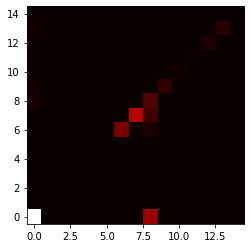

In [41]:
plt.imshow(num_rules, cmap='hot', interpolation='nearest', origin='lower')